# Shape analysis of closed curves

In [3]:
import os
import subprocess

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(geomstats_gitroot_path[:-1])

print("Working directory: ", os.getcwd())

Working directory:  /Users/Utilisateur/Python/geomstats


In [4]:
import geomstats.backend as gs
import json
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    insert_zeros, 
    DynamicProgrammingAligner
)

INFO: Using numpy backend


In [5]:
def load_curve(filename):
    f = open(filename)
    data = json.load(f)

    points_list = data['points']
    x_coord = []
    y_coord = []
    for point in points_list:
        x_coord.append(point['x'])
        y_coord.append(point['y'])

    return gs.vstack((x_coord, y_coord)).T


def plot_curve(curve, fmt="o-k", translation=None, ax=None, add_origin=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    if add_origin:
        curve = insert_zeros(curve, axis=-2)
        if translation is not None:
            curve = curve + translation
    ax.plot(curve[:, 0], curve[:, 1], fmt)

    return ax


def resample(curve, k_sampling_points):
    t_space = gs.linspace(0., 1., curve.shape[0])
    spline_fun = make_interp_spline(t_space, curve)
    sampling_points = gs.linspace(0., 1., k_sampling_points)
    return spline_fun(sampling_points)


def plot_geodesic(geod, n_times_plot, translation=None, ax=None, figsize=(7, 7)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    geod = insert_zeros(geod, axis=-2)

    if translation is not None:
        geod = geod + gs.expand_dims(translation, axis=-2)

    ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
    ax.plot(geod[-1, :, 0], geod[-1, :, 1], "or")

    n_times = geod.shape[0]
    indices = gs.floor(gs.linspace(0., n_times - 1, n_times_plot)).astype('int')
    for i in range(1, n_times_plot - 1):
        ax.plot(geod[indices[i], :, 0], geod[indices[i], :, 1], "k")

    return ax

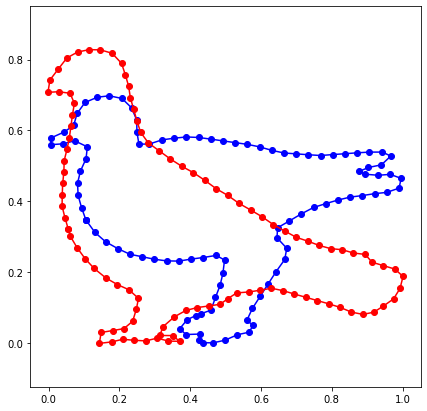

In [12]:
filename_a = 'geomstats/datasets/data/shapes/bird-1.json'
filename_b = 'geomstats/datasets/data/shapes/bird-18.json'

curve_a = load_curve(filename_a)
curve_b = load_curve(filename_b)

k_sampling_points = 100
curve_a = resample(curve_a, k_sampling_points)
curve_b = resample(curve_b, k_sampling_points)

ax = plot_curve(curve_a, 'o-b', add_origin=False)
plot_curve(curve_b, 'o-r', ax=ax, add_origin=False)
plt.axis('equal')
plt.show()

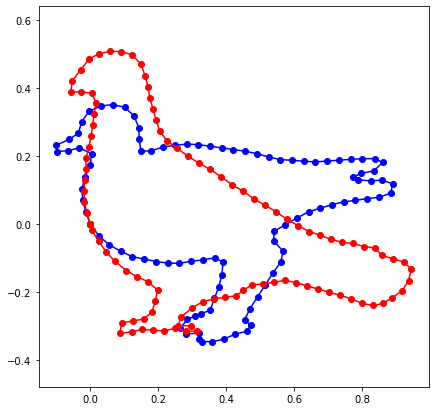

In [13]:
curves_r2 = DiscreteCurvesStartingAtOrigin(2, k_sampling_points)

curve_a0 = curves_r2.projection(curve_a)
curve_b0 = curves_r2.projection(curve_b)

ax = plot_curve(curve_a0, 'o-b')
plot_curve(curve_b0, 'o-r', ax=ax)
plt.axis('equal')
plt.show()

In [14]:
n_times = 100
times = gs.linspace(0., 1., n_times)
geodesic_1 = curves_r2.metric.geodesic(curve_a0, curve_b0)(times)

In [15]:
curves_r2.equip_with_group_action("reparametrizations")
curves_r2.equip_with_quotient_structure()

geodesic_2 = curves_r2.quotient.metric.geodesic(curve_a0, curve_b0)(times)

In [16]:
curves_r2.fiber_bundle.aligner = DynamicProgrammingAligner()

geodesic_3 = curves_r2.quotient.metric.geodesic(curve_a0, curve_b0)(times)

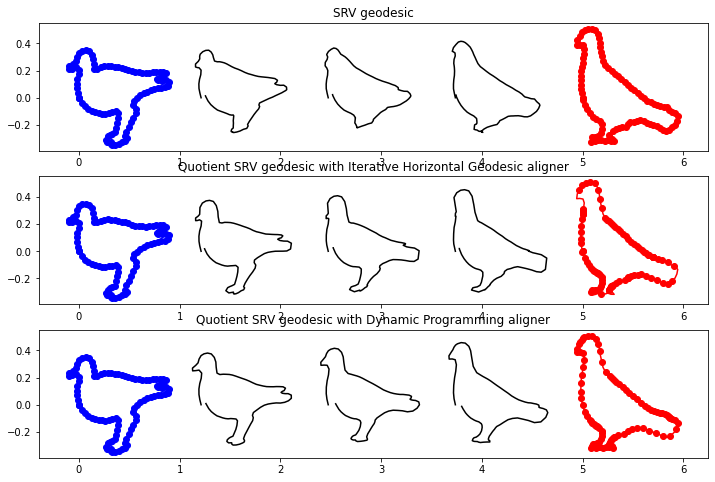

In [20]:
vec = gs.array([5., 0.])
translation = gs.linspace(gs.zeros(2), vec, n_times)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
plot_geodesic(geodesic_1, 5, translation=translation, ax=ax1)
ax1.set_title('SRV geodesic')

plot_geodesic(geodesic_2, 5, translation=translation, ax=ax2)
plot_curve(curve_b0, 'r', ax=ax2, translation=vec)
ax2.set_title('Quotient SRV geodesic with Iterative Horizontal Geodesic aligner')

plot_geodesic(geodesic_3, 5, translation=translation, ax=ax3)
plot_curve(curve_b0, 'r', ax=ax3, translation=vec)
ax3.set_title('Quotient SRV geodesic with Dynamic Programming aligner')
plt.show()